# Navier Stokes in a pipe flow (stationary 2D) with hard constraints

We solve the stationary Navier Stokes PDE:

$$
\begin{cases}
\nabla\cdot\mathbf{u}=0,\\
(\mathbf{u}\cdot\nabla)\mathbf{u} + \frac{1}{\rho}\nabla p - \theta \nabla^2\mathbf{u}=0.
\end{cases}
$$

This becomes in 2D, with $\mathbf{u}=\begin{pmatrix}u_x \\ u_y\end{pmatrix}$


$$
\begin{cases}
\frac{\partial}{\partial x} u_x + \frac{\partial}{\partial y} u_y = 0 \\
\begin{pmatrix}u_x\frac{\partial}{\partial x} u_x + u_y\frac{\partial}{\partial y} u_x \\
u_x\frac{\partial}{\partial x} u_y + u_y\frac{\partial}{\partial y} u_y  \end{pmatrix} +
\frac{1}{\rho} \begin{pmatrix} \frac{\partial}{\partial x} p \\ \frac{\partial}{\partial y} p \end{pmatrix}
- \theta
\begin{pmatrix}
\frac{\partial^2}{\partial x^2} u_x + \frac{\partial^2}{\partial y^2} u_x \\
\frac{\partial^2}{\partial x^2} u_y + \frac{\partial^2}{\partial y^2} u_y
\end{pmatrix} = 0\\
\end{cases}
$$


With the boundary condition:
$$
\begin{cases}
u(x, \frac{d}{2}) = -u(x, \frac{d}{2})=0, \forall x \text{ (boundary condition) }\\
p(x_{min}, y)=0 \text{ and } p(x_{max}, y)=0.1, \forall y \text{ (boundary condition) }
\end{cases}
$$

The domain is defined with $x\in[0,L]$ and $y\in[-R, R]$. __Note__ that because of the central symmetry with respect to the centerline of the tube, we only consider the $y$ axis which will represent the cross section

This notebook aims at reproducing the exampleof section 3.1 of [*Surrogate modeling for fluid flows based on physics-constrained deep learning without simulation data*, Sun et al. 2020](https://www.sciencedirect.com/science/article/pii/S004578251930622X). 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

2024-03-04 13:46:07.298126: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Create a DataGenerator object and set up some geometry. Following the [authors' implementation](https://github.com/Jianxun-Wang/LabelFree-DNN-Surrogate/blob/master/Tutorial/PipeFlow.ipynb), we set a pipe length $L=1$ and a pipe radius$R=0.05$. Following the authors, we also simplify the problem because of its geometry: the solution is symmetric with respect to the center of the pipe, at a given point $x\in[0, L]$. Therefore we only need one axis representing a pipe cross section and one axis representing the pipe length.

In [5]:
L = 1
R = 0.05

p_out = 0
p_in = 0.1

In [6]:
n = 1000
nb = None
omega_batch_size = 32
omega_border_batch_size = None
dim = 2
xmin = 0
xmax = xmin + L
ymin = -R
ymax = ymin + 2 * R
# zmin = -R
# zmax = zmin + 2 * R

method = "uniform"
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDEStatio(
    subkey,
    n,
    nb,
    omega_batch_size,
    omega_border_batch_size,
    dim,
    (xmin, ymin),
    (xmax, ymax),
    method
)

__Note:__ that we choose a very simple data generator and no boundary condition despite the pipe-like geometry. Indeed, we choose to follow the author's hard coded boundary constraints. The neural network outputs are then multiplied with a factor which enforces the constraints. We impose the so-called _slip-condition_ on the borders, ie, the fluid has a null speed on the borders.

Create the neural network architecture for the PINN with `equinox`. We have two Pinns for the velocity field `u` and for the pressure field `p`. The first one is vectorial (2D) the second one is scalar.

In [7]:
eqx_list = [
    [eqx.nn.Linear, 2, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 2],
]
key, subkey = random.split(key)
u_output_transform = lambda pinn_in, pinn_out: pinn_out * (R**2 - pinn_in[1] ** 2)
u = jinns.utils.create_PINN(subkey, eqx_list, "statio_PDE", 2, output_transform=u_output_transform)

eqx_list = [
    [eqx.nn.Linear, 2, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 1],
]
key, subkey = random.split(key)
p_output_transform = lambda pinn_in, pinn_out: (
         (pinn_in[0] - xmin) / (xmax - xmin) * p_out
         + (xmax - pinn_in[0]) / (xmax - xmin) * p_in
         + (xmin - pinn_in[0]) * (xmax - pinn_in[0]) * pinn_out
     )
p = jinns.utils.create_PINN(subkey, eqx_list, "statio_PDE", 2, output_transform=p_output_transform)

In [8]:
u_init_nn_params = u.init_params()
p_init_nn_params = p.init_params()

Plot the initial PINN outputs

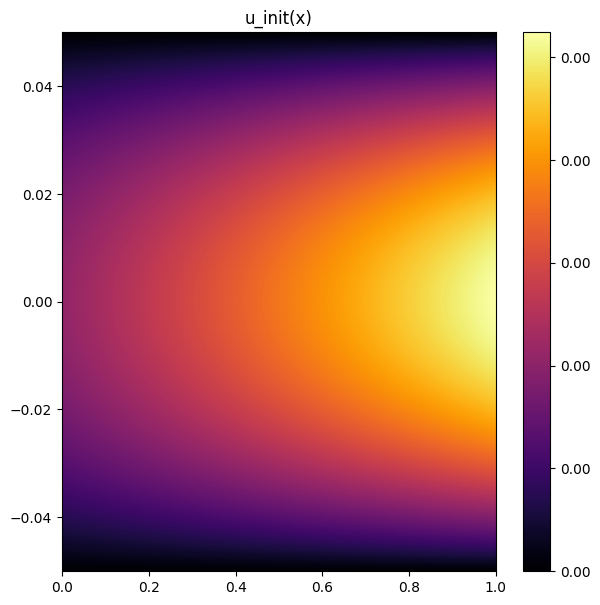

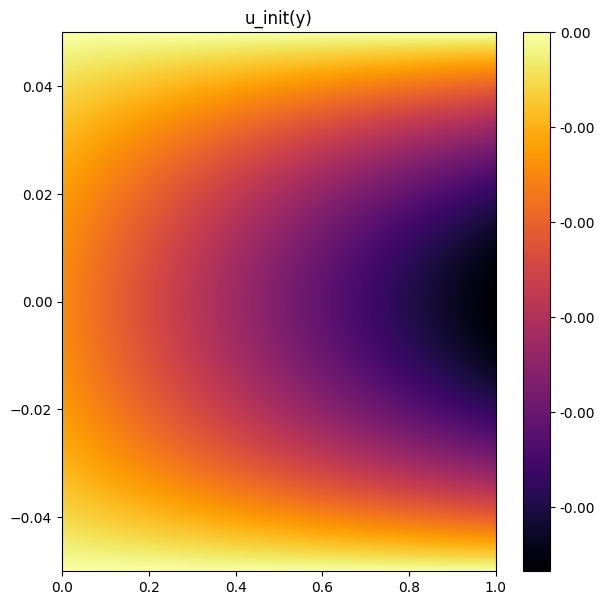

In [9]:
nx, ny = 1000, 1000
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

u_xinit = lambda x: u(x, u_init_nn_params)[0]
jinns.data.plot2d(
    fun=u_xinit,
    xy_data=val_xy_data,
    title="u_init(x)"
)

u_yinit = lambda x: u(x, u_init_nn_params)[1]
jinns.data.plot2d(
    fun=u_yinit,
    xy_data=val_xy_data,
    title="u_init(y)"
)

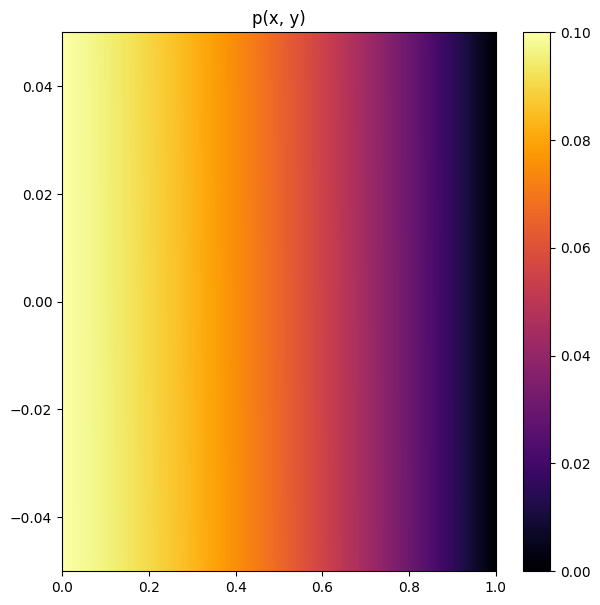

In [10]:
jinns.data.plot2d(
    fun = lambda x: p(x, p_init_nn_params),
    xy_data=val_xy_data,
    title = "p(x, y)"
)

## Model parameters

Here we set the density $\rho=1$ and we simplify the problem with respect to the article: $\theta$ is the viscosity parameter which we fix and feed as input to the PINN as done in the article; $\theta=0.00061$

In [11]:
rho = 1.
nu = 0.00061

Delta_p = 0.1
d = 2 * R

A set of parameters as required by the losses' `evaluate`. Here we adapt to the particular dynamic loss which requires the keys `u` and `p`.

In [12]:
# initiate parameters dictionary
init_params = {}
init_params['nn_params'] = {
    "u": u_init_nn_params,
    "p": p_init_nn_params
}
init_params["eq_params"] = {"rho":rho, "nu":nu}

## Analytical solution
In this case, the analytical solution is known:
$$
u_a = \frac{\Delta p}{2\theta\rho L}(\frac{d^2}{4} - y^2)
$$

Text(0.5, 1.0, 'True solution along a cross section')

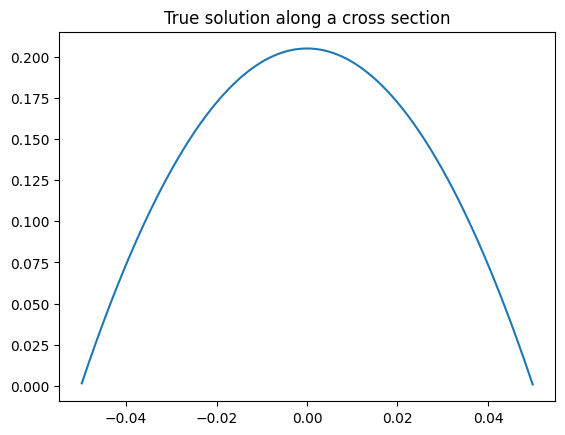

In [13]:
def u_true(y):
    return Delta_p / (2 * nu * rho * L) * ((d / 2) ** 2 - y ** 2)

plt.plot(train_data.omega[:, 1].sort(axis=0), vmap(u_true, (0), 0)(train_data.omega[:, 1].sort(axis=0)))
plt.title(r"True solution along a cross section")

## Observations

We create some noisy observations to illustrate this use-case in **jinns**. Note that the example is simple enough and observations are not needed to estimate the true solution. Note that we will only have observations for the velocity PINN $u$.

In [14]:
key, subkey = jax.random.split(key)
n_obs = 2500
x = jax.random.uniform(subkey, shape=(n_obs, 1), minval=(xmin), maxval=(xmax))
y = jax.random.uniform(subkey, shape=(n_obs, 1), minval=(ymin), maxval=(ymax))

obs = u_true(y)

obs_batch = jnp.concatenate([
    x, y, obs
    ],
    axis=-1
)

In [15]:
key, subkey = random.split(key)
obs_batch_size = omega_batch_size # must be equal to time_batch_size !
obs_data = jinns.data.DataGeneratorObservationsMultiPINNs(
    omega_batch_size,
    observed_pinn_in_dict={"u":obs_batch[:, 0:2], "p":None},
    observed_values_dict={"u":obs_batch[:, 2:3], "p":None},
    key=subkey,
)

## Loss construction

In [16]:
mc_loss = jinns.loss.MassConservation2DStatio(nn_key='u')
ns_loss = jinns.loss.NavierStokes2DStatio(u_key='u', p_key='p')

In [17]:
loss_weights = {"dyn_loss":1., "observations":1.}
    
loss = jinns.loss.SystemLossPDE(
    u_dict={'u':u, 'p':p},
    loss_weights=loss_weights,
    dynamic_loss_dict={'mass_conservation':mc_loss, 'navier_stokes':ns_loss},
    nn_type_dict={'u':'nn_statio', 'p':'nn_statio'},
    obs_slice_dict={'u':jnp.s_[0:1], 'p':jnp.s_[...]}
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:353: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


In [18]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    batch = jinns.data.append_obs_batch(train_data.get_batch(), obs_data.get_batch())
)


l_tot, dict_losses = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in dict_losses.items()} }")

total loss: 0.04
Individual losses: {'boundary_loss': '0.00', 'dyn_loss': '0.01', 'initial_condition': '0.00', 'norm_loss': '0.00', 'observations': '0.02', 'sobolev': '0.00'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [19]:
params = init_params

In [20]:
# Optimizer
import optax

tx = optax.adam(learning_rate=1e-4)

In [21]:
n_iter = int(50000)

In [22]:

params, total_loss_list, loss_by_term_dict, data, loss, _, _ , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    obs_data=obs_data,
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:353: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(
/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:353: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(
/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:353: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


Iteration 0: loss value = 0.030507374554872513


  0%|          | 0/50000 [00:00<?, ?it/s]

Iteration 1000: loss value = 0.020897889509797096
Iteration 2000: loss value = 0.024327073246240616
Iteration 3000: loss value = 0.020758843049407005
Iteration 4000: loss value = 0.0168925728648901
Iteration 5000: loss value = 0.015154857188463211
Iteration 6000: loss value = 0.012105865404009819
Iteration 7000: loss value = 0.009195663034915924
Iteration 8000: loss value = 0.0075170258060097694
Iteration 9000: loss value = 0.004729302134364843
Iteration 10000: loss value = 0.004299730062484741
Iteration 11000: loss value = 0.0033681653439998627
Iteration 12000: loss value = 0.002313267905265093
Iteration 13000: loss value = 0.001164023531600833
Iteration 14000: loss value = 0.0008363761007785797
Iteration 15000: loss value = 0.0004354153643362224
Iteration 16000: loss value = 0.00019027406233362854
Iteration 17000: loss value = 5.2514740673359483e-05
Iteration 18000: loss value = 1.1418993381084874e-05
Iteration 19000: loss value = 5.992861815684591e-07
Iteration 20000: loss value = 2

/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:353: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


## Results

Plot the loss values

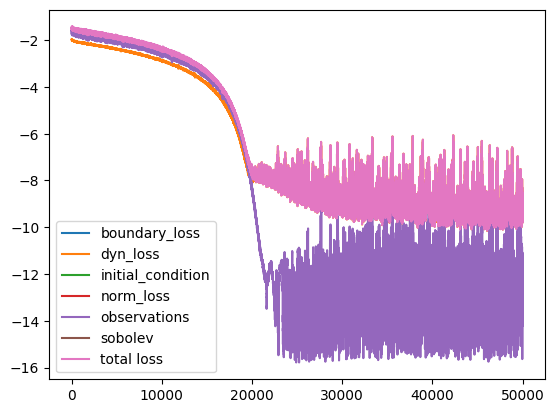

In [23]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the ODE solutions learned by the PINN

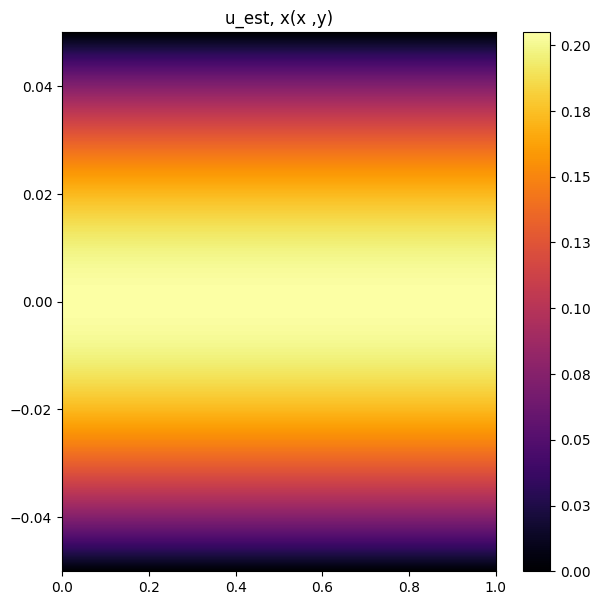

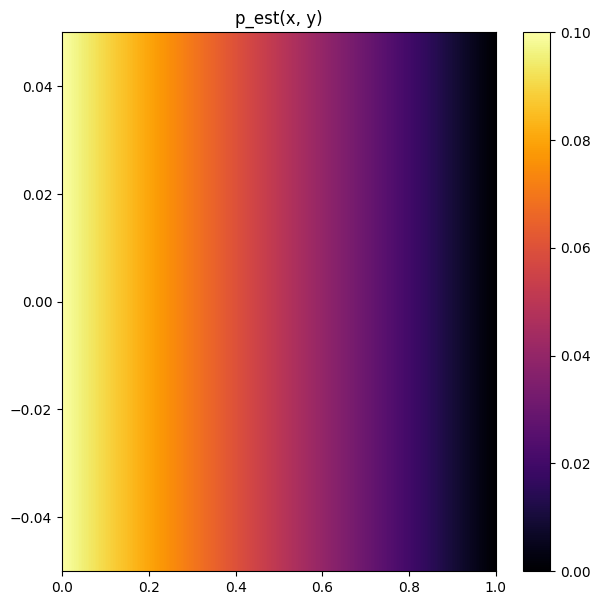

In [24]:
jinns.data.plot2d(
    fun = lambda x: u(x, params['nn_params']['u'])[0],
    xy_data = val_xy_data,
    title="u_est, x(x ,y)"
)

jinns.data.plot2d(
    fun = lambda x: p(x, params['nn_params']['p']),
    xy_data = val_xy_data,
    title="p_est(x, y)"
)

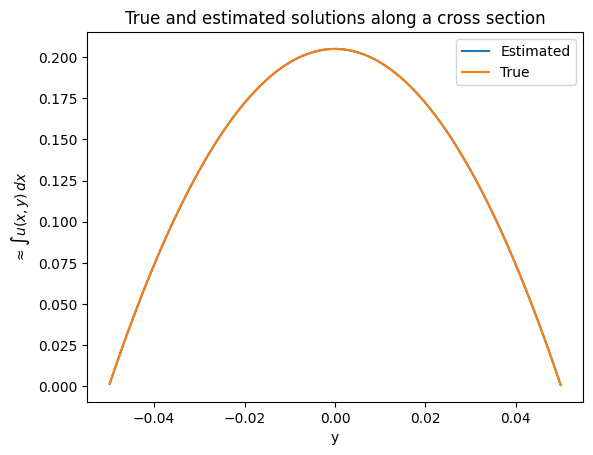

In [25]:
v_u_est_y = vmap(
    # compute average over array x with y_j fixed.
    lambda x, y_j: vmap(lambda z: u(jnp.stack([z, y_j], axis=-1), params["nn_params"]["u"])[0], 
                        0, 0)(x).mean(), 
    (None, 0), 
    0)


plt.plot(train_data.omega[:, 1].sort(axis=0),
         v_u_est_y(train_data.omega[:, 0].sort(axis=0),
                   train_data.omega[:, 1].sort(axis=0)),
         label="Estimated")
plt.plot(train_data.omega[:, 1].sort(axis=0),
         vmap(u_true, (0), 0)(train_data.omega[:, 1].sort(axis=0)),
         label="True")
plt.xlabel("y")
plt.ylabel(r"$\approx \int u(x, y) \, dx$")
plt.legend()
plt.title(r"True and estimated solutions along a cross section")
plt.show()